In [1]:
import spot
spot.setup(show_default=".A")  # hide acceptance conditions
from spot.jupyter import display_inline

# MTBDDs

(If you know Mona's MTBDD, skip directly to the last paragraph of this section.)

A Binary Decision Diagram represents a Boolean formula $f(a_1,a_2,\ldots,a_n): \mathbb{B}^n\to\mathbb{B}$ as a DAG in which each internal node is labeled by one of the $a_i$s (always in the same order) and has two children corresponding to $a_i=\bot$ and $a_i=\top$.  The leaves of the DAG represent the values of $f$ when its arguments are assigned to the values represented to the path leading to that leave.   This is typically implemented by storing all nodes in an array of triplets of integers $(i,low,high)$ where $i$ denotes variable $a_i$, $low$ is the index of the triplet for the $a_i=\bot$ branch, and $high$ is the index of the triplet for the $a_i=\top$ branch.  
Special triplets $(n+1,0,0)$ and $(n+1,1,1)$ are stored at index 0 and 1 and represent the output values $\bot$ and $\top$.  (The fact that they are stored at indices 0 and 1 makes it easy to recognize those constants from the indices without having to look at the triplets.)

Multi-Terminal BDDs generalize the co-domain of the representable functions to $\mathbb{N}$. So the DAG now stores functions of the form $f(a_1,a_2,\ldots,a_n): \mathbb{B}^n\to\mathbb{N}$.  In this context, each leaf of the DAG should store a value $v\in\mathbb{N}$.  Mona represents this by a triplet of the form $(\mathrm{MAXINT}, 1, v)$.
(The value 1 does not mean anything, but both Mona and BuDDy use $low=-1$ to denote a unused triplet, so that makes it dangerous to repurpose )

In both cases, a typical binary operation takes two BDDs, recursively descends in both BDDs in a way to explore all combinations of variables, combine the leaves once they are reached on both sides, and rebuild the resulting BDD from the bottom up while backtracking.  The combinations of leaves correspond to Boolean operations in the $\mathbb{B}$ case.  They are arbitrary $\mathbb{N}\times\mathbb{N}\to\mathbb{N}$ function in the MTBDD case.   However, even of the two cases look very similar at a high-level, they are quite different in practice:

- In the Boolean case, the set of Boolean operations that can be used for combinations is small.  Thefore a BDD library can implement them all, share a cache for all these operations, and implement shortcuts (for instance $\top\land f$ can return $f$ right away without having to recurse all the way down to the leaves to rebuild $f$ from the bottom).

- In the Multi-Terminal case, an arbitrary $\mathbb{N}\times\mathbb{N}\to\mathbb{N}$ operation has to be supplied by the user as a function pointer.  The fact that the combination function work only on terminal, and that the `apply` function does not know what it does makes it impossible to "shortcut" the recursion.  It also makes it difficult to cache multiple operations in the same cache because the combination function will likely use some global state (the function pointer is therefore not a good key for a hash table).  Mona solves the cache issue by leaving letting users manage the cache.


The version of BuDDy that ships with Spot has already been modified in many ways.  It now supports integer-valued terminals **in addition to the usual *false* and *true* nodes**.  You can build pure MTBDDs that do not use *false* and *true*, like in Mona.  You can build standard BDDs that you only *false* and *true*, like BuDDy has always supported.  And you may also build MTBDDs that mix integer-terminals and Boolean leaves.  The latter mix makes sense when some of the terminal would have semantics equivalent to *false* and *true*, and the applied operations also behave like Boolean operations: in that case we can specify the Boolean operation performed
(in addition to passing the combination function that performs it on terminal) so that `apply()` knows how to shortcut its recursion when it reaches the *false* or *true* nodes on for one of its arguments.

# Conversion from LTLf to MTBDD

Given an LTLf formula labeling *one* automaton state, we want to construct an MTBDD that represents the set of its outgoing transitions: terminals will represent LTL formulas labeling the destination states, and one path in such an MTBDD will represent one outgoing transition.  The $tr$ function defined below constructs such an MTBDD.  (A full automaton will eventually be represented by an array of MTBDDs, one per state.)

We use the classical semantics of LTLf interpreted over non-empty finite words.  (No formula is satisfied by the empty word, unlike in some papers.)


In this context, we will use the terminals to represent pairs $(f,b)$ where $f$ is an LTLf formula, and $b$ is a Boolean.  For simplicity we write $term(f,b)$ but in practice the terminal stores an integer, and this integer allows to find $f$ and $b$.  The terminal $term(f,b)$ can be understood as representing a destination state labeled by $f$, and that state should be accepting iff $b=\top$.  Or equivalently, you
could think of $term(f,\top)$ as meaning $f\lor \varepsilon$; i.e., $b$ indicate whether the empty word is meant to be accepted from that destination state.

We can apply a binary operator $\odot\in\{\land,\lor,\rightarrow,\leftrightarrow,\oplus\}$ to two MTBDD using the aforementioned `apply()` algorithm, by using the convention that $term(f_1,b_1)\odot term(f_2,b_2) = term(f_1\odot f_2,b_1\odot b_2)$.  The negation
operator is handled similarly: $\lnot term(f,b) = term(\lnot f,\lnot b)$.

The translation of an LTLf formula to MTBDD is done using the following rules:

  - $tr(\top) = term(\top,\top)\qquad$   **(See optimization below)**
  - $tr(\bot) = term(\bot,\bot)\qquad$   **(See optimization below)**
  - $tr(a) = a\land term(\top, \top)$  for any atomic proposition $a$
  - $tr(\lnot \alpha) = \lnot tr(\alpha)$
  - $tr(\alpha \odot \beta)= tr(\alpha)\odot tr(\beta)$ for any $\odot\in\{\land,\lor,\rightarrow,\leftrightarrow,\oplus\}$
  - $tr(\mathop{\mathsf{X}}\alpha) = term(\alpha,\top)$
  - $tr(\mathop{\mathsf{X[!]}}\alpha) = term(\alpha,\bot)$
  - $tr(\alpha \mathbin{\mathsf{U}} \beta) = tr(\beta) \lor (tr(\alpha)\land term(\alpha \mathbin{\mathsf{U}} \beta, \bot)$
  - $tr(\alpha \mathbin{\mathsf{W}} \beta) = tr(\beta) \lor (tr(\alpha)\land term(\alpha \mathbin{\mathsf{W}} \beta, \top)$
  - $tr(\alpha \mathbin{\mathsf{M}} \beta) = tr(\beta) \land (tr(\alpha)\lor term(\alpha \mathbin{\mathsf{U}} \beta, \bot)$
  - $tr(\alpha \mathbin{\mathsf{R}} \beta) = tr(\beta) \land (tr(\alpha)\lor term(\alpha \mathbin{\mathsf{W}} \beta, \top)$
  - $tr(\mathop{\mathsf{F}}\alpha) = tr(\alpha)\lor term(\mathop{\mathsf{F}}\alpha,\bot)$
  - $tr(\mathop{\mathsf{G}}\alpha) = tr(\alpha)\land term(\mathop{\mathsf{G}}\alpha,\top)$
  
Note that the argument of $tr$ does not have to be in negative normal form.

**Optimization:**  The above definition of $tr$ creates a *pure* MTBDD in which all leaves are terminal nodes.  This unfortunately implies that whenever two MTBDD are combined, `apply()` has to recurse to the bottom of both operands to perform operations on terms.  To help `apply()` shortcut some operations, we replace $term(\top,\top)$ and $term(\bot,\bot)$ by the *true* and *false* BDD constants respectively.  A consequence of that is that for any Boolean formula $b$, $tr(b)$ is the traditionally BDD representing the formula $b$.


**Implementation details:** Assuming there exists a mapping $M$ from LTLf formulas to integers, we actually represent $term(f,b)$ as a terminal with integer value $2M(f)+b$.  In other words the the lowest significant bit of the terminal value is used to rememeber whether the associated formula is allowed to satisfy the empty word.

**Related work**

This draws inspiration from several sources.

- [Brzozowski's derivatives](https://dl.acm.org/doi/pdf/10.1145/321239.321249) is a way to construct a DFA from a regular expression.   The automaton is labeled by regular expressions, successors computed based on a function $\delta_\ell(r)$ that computes the regular expression that one should go to after reading $\ell$ from a state labeled by $r$.  The technique support regular expression using any Boolean operator, not just disjunction.  However for each state, it require iterating over $\ell\in\Sigma$, so this can become quite slow for a large $\Sigma$.
- [Giacomo's et al. formula progressions](https://www.ijcai.org/proceedings/2022/0359.pdf) is the equivalent of Brzozowski's derivatives, but applied to LTLf with semantics that consider the empty word.  It require the formula to be in negative normal form, but that appears to be a consequence of allowing the empty word.  Since LTLf is defined over a propositional alphabet, we have $\Sigma=2^{AP}$, and for each state we unfortunately have to loop over all letters $\ell\in\Sigma$ to compute the progressions, as in Brzozowsk's derivatives.
- [Antimirov's linear forms](https://www.sciencedirect.com/science/article/pii/0304397595001824/pdf?md5=8f60737427b90e85a0725fd7cc8647c8&pid=1-s2.0-0304397595001824-main.pdf) is a way compute all successors of a state labeld by a regular expression $r$ in a single pass.  The linear form $\mathit{lf}(r)$ is a set $\{(\ell_1,r_1),...,(\ell_n,r_n)\}$ where $l_i$ are letters and $r_i$s are regular expressions, such that $L(r)=\bigvee_i \ell_i\cdot L(r_i)$.  One can use that to construct an NFA (when multiple $\ell_i$ can be equal) or a DFA (after merging the pairs with identical $\ell_i$:  $\{...,(\ell,r),(\ell,s),...\} \to \{...,(\ell,r\lor s),...\}$).  Altought Antimirov only worked with classical regular expression where disjunction is the only Boolean operator, *deteriministic* linear forms are easy to adapt to arbitrary Boolean operators.  The linear form $\mathit{lf}(r)$ can be seen as a way to compute all derivatives in a single pass (the set of formulas obtained are not always syntactically equal to the set of derivatives, but they are equivalent).
- [Martin et al.'s linear forms](https://www.lrde.epita.fr/~adl/dl/adl/martin.24.ciaa.pdf) is an adaptation of Antimirov's linear forms to the semi-extended regular expressions (SERE) that appear in PSL or SVA.  These expressions are defined over a propositional alphabet, so that makes the use of linear-forms (that can be computed in a singled pass independant on the size of $\Sigma$) pertinent.   This work also shows that two states that can have the same linear form can be merged, and that this works nicely with transition-based acceptance.
- [Couvreur's LTL translation](https://www.lrde.epita.fr/dload/spot/bib/couvreur.99.fm.pdf) creates transition-based generalized Büchi automata from LTL.  It uses BDDs to encode the outgoing transitions of a state labeled by a LTL formula. Extra BDD variables are used to store destination state as well as promises that have yet to be fulfilled.  That BDD is computed recursively from the LTL label, using a set of rules similar to those of $tr$.  Transition can be recovered from the BDD by computing its prime implicants.   This is the base of LTL translation in Spot, and computing those prime implicants is a costly part of the process. 
- [Mona](https://www.brics.dk/mona/mona14.pdf) uses MTBDDs to represent DFAs.  My understanding is that their translation of WS1S to DFA is implemented as DFA operations over that representation.  They do not really build their DFA state-by-state as in the previous techniques.

An MTBDD is actually a good data structure to represent a *deterministic linear form*.  The MTBDD computed by $tr(\alpha)$ above can be seen as a symbolic linear form for $tr(\alpha)$.  This can equivalently be seen as a way to compute all formula progressions at once (with the difference that we exclude the empty word from the semantics).  As done in Martin at al.'s paper, we can merge two states that have the same $tr$ and benefit from transition-based acceptance (as will be shown below).

# Examples of outputs for $tr(\cdot)$

Recall that $tr(\alpha)$ computes an MTBDD representing the outgoing edges of a *single* state labeled by $\alpha$.

In [2]:
# The C++ version of the above tr() function isn't user-accesible, but we can 
# fake it by displaying only the first state of the automaton.  The function
# ltlf_to_mtdfa is dicussed in the next section.
def tr(f):
    return spot.ltlf_to_mtdfa(f, False).show(state=0)

The following example shows how the two MTBDDs for $a$ and $\mathop{\mathsf{X}}a$ can be combined in an MTBDD for $a\land \mathop{\mathsf{X}}$

The nodes looking like inverted houses at the top of the DAGs are not part of the MTBDD, they are just giving a name to that MTBDD root to help us read the picture.   A terminal $term(f,b)$ is shown as a house labeled by $f$, and that house has a double enclosure iff $b=\top$.  The BDD constants *false* and *true* are shown in boxes, but since *true* is actually a replacement for $term(\top,\top)$, it is also displayed with a double enclosure.

Below we learn that from a state labeled by $a\land \mathop{\mathsf{X}}$, we should not read $\lnot a$ (because that path would go to *false*, which is not accepting), and that if we read $a$, we can either accept the word if that was the last letter (because the terminal reached is marked as accepting), or go to a state labeled by formula $b$ to read the suffix of the word.

In [3]:
display_inline(tr("a"), tr("Xb"), tr("a & Xb"))

Here are the outputs of $tr$ on some basic operators, just to double-check their definitions.

In [4]:
display_inline(tr("0"), tr("1"), tr("a <-> b"))
display_inline(tr("Xa"), tr("X[!]a"), tr("Fa"), tr("Ga"))
display_inline(tr("a U b"), tr("a W b"), tr("a R b"), tr("a M b"))

The following plays with Boolean operators that are not used when forulas are in negative normal forms.  However this translation does not require the input to be in negative normal form.

In [5]:
display_inline(tr("Ga"), tr("!Ga"), tr("F!a"), tr("Fb"))
display_inline(tr("Ga -> Fb"), tr("F!a | Fb"))
display_inline(tr("Ga <-> Fb"), tr("Fa xor Gb"))

# Building a MTBDD-based DFA

Iterating the use of `tr()` over all formulas appearing on terminals, we can build a MTBDD-based DFA.  This is an array of MTBDDs, as in Mona.  We call those MTDFA.   The initial MTBDD (or initial state if you prefer) is indicated with a down arrow.  The different MTBDD denoting the states can of course share part of their BDDs.

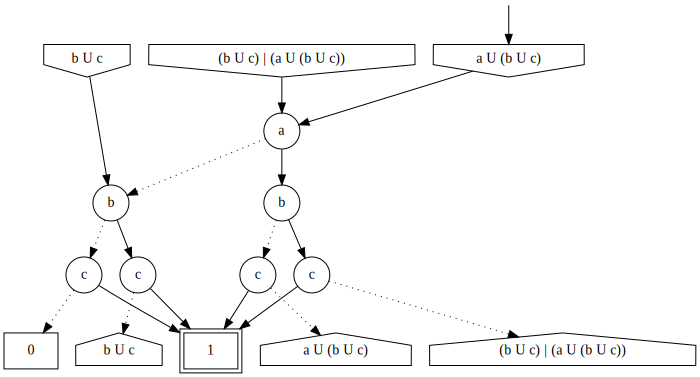

In [6]:
spot.ltlf_to_mtdfa("a U b U c", False)



Different LTLf formulas can have the same MTBDD representation. Above, we can see that $tr(a \mathbin{\mathsf{U}} (b \mathbin{\mathsf{U}} c))=tr((b \mathbin{\mathsf{U}} c) \lor a \mathbin{\mathsf{U}} (b \mathbin{\mathsf{U}} c))$.

Since the successors of these states are identical, it makes sense to fuse them.  This is actually what `ltlf_to_mtdfa()` does by default.

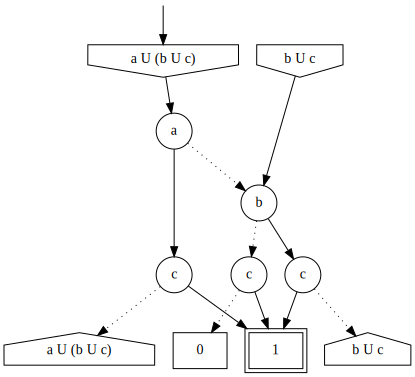

In [7]:
aut1 = spot.ltlf_to_mtdfa("a U b U c")
aut1

When fusing states, we must be cautious about the acceptance of these states.

Here is an example where this is clearly visible:

In [8]:
display_inline(spot.ltlf_to_mtdfa("GFa", False), spot.ltlf_to_mtdfa("GFa"))

Here, $(\mathop{\mathsf{F}}a)\land (\mathop{\mathsf{G}}\mathop{\mathsf{F}}a)$ and $\mathop{\mathsf{G}}\mathop{\mathsf{F}}a$ are equivalent, so the algorithm simply remembers the first formula it has seen.  Distinguishing the acceptance of the terminal nodes is not a problem.

**Implementation details:** A MTDFA is represented using two arrays:
- `formula names[n];`
- `bdd states[n];`


The MTBDD stored in `states[i]` encodes the outgoing edges of state `i`.  The terminal in those MTBDDs store integers of the form `2j+a` were `j` is the index of the destination state, and `a` is a boolean indicating whether that destination is accepting.  The `names` array is purely cosmetic: `names[i]` is the LTLf formula associated to state `i`, it can be used for rendering.   State 0 is always the initial state.

Automaton `aut1` above automaton has `n=2` roots for `a U b U c` and `b U c`, but one will usually want to consider `1` as a state.  The state for formula `1` is not stored, because it is always encoded as *true*.  (People who prefer to work with complete DFAs, might want to consider `0` as a state too.)  The `mtdfa` class has two methods to return its size: `num_roots()` counts the number of roots stored in the DFA (i.e., the size of the `states` and `names` array), and `num_states()` adds one to `num_roots()` if any root can reach `true`.

In [9]:
print(aut1.num_roots(), aut1.num_states())

2 3


# Conversion from MTBDD-DFA to TwA

TwA is the standard data-structure of Spot used to represent ω-automata.  
Since Spot has no class for representing DFA explicitely, this conversion is just a hack to allow a more traditional representation where we just ignore the acceptance condition.

The conversion to transition-based acceptance is strightfoward: each root of the MTBDD corresponds to a state, and each path from a root to a terminal corresponds to a transition, and that transition is accepting if the terminal is odd.  Paths going to the *true* BDD constant become transitions leading to an accepting sink.

With transition-based DFA, a word is accepted if its last letter was read by a transition marked with a ⓿.

(Conversion to DFA with state-based acceptance isn't implemented; but it would not be very difficult.)

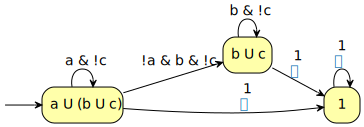

In [10]:
spot.ltlf_to_mtdfa("a U b U c").as_twa()

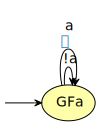

In [11]:
spot.ltlf_to_mtdfa("GFa").as_twa()

# More examples

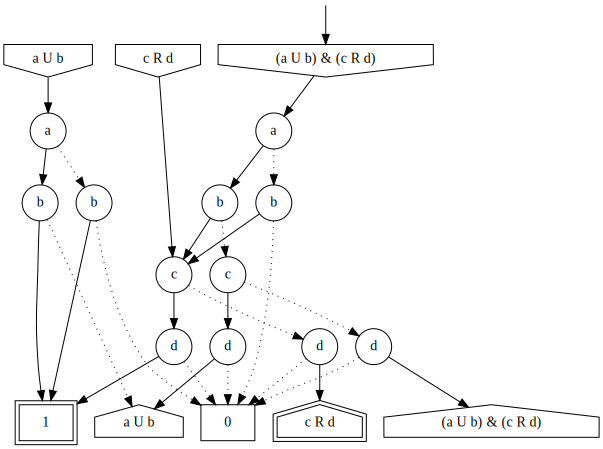

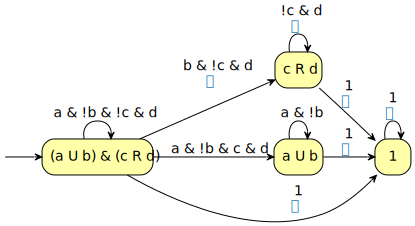

In [12]:
a1 = spot.ltlf_to_mtdfa("(a U b) & (c R d)") 
display(a1, a1.as_twa())

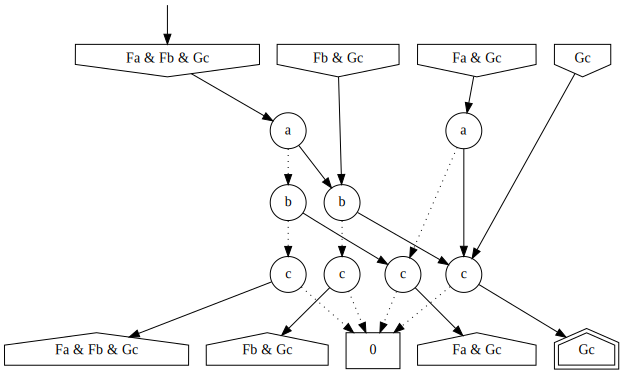

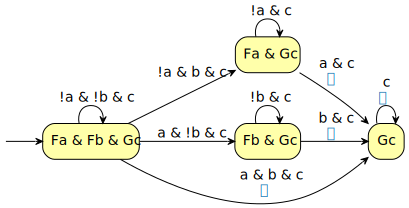

In [13]:
a2 = spot.ltlf_to_mtdfa("Fa & Fb & Gc") 
display(a2, a2.as_twa())

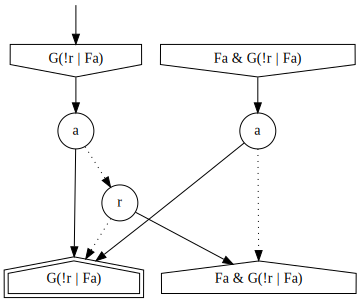

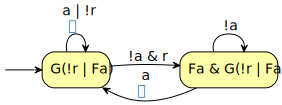

In [14]:
a3 = spot.ltlf_to_mtdfa("G(!r | Fa)") 
display(a3, a3.as_twa())

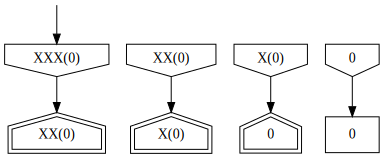

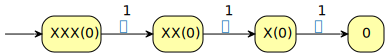

In [15]:
a4 = spot.ltlf_to_mtdfa("XXX(0)") 
display(a4, a4.as_twa())

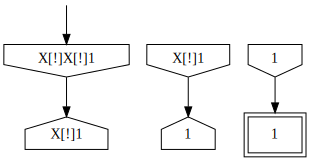

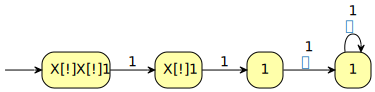

In [16]:
a5 = spot.ltlf_to_mtdfa("X[!]X[!]1") 
display(a5, a5.as_twa())

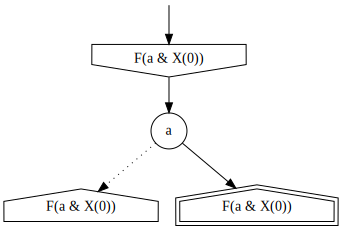

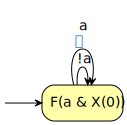

In [17]:
# The last step has to match "a".  This is equivalent to GFa or FGa in LTLf.
a6 = spot.ltlf_to_mtdfa("F(a & X(0))") 
display(a6, a6.as_twa())

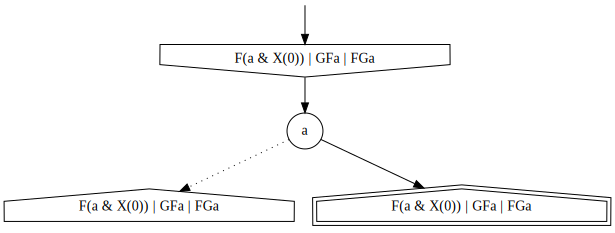

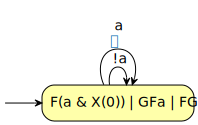

In [18]:
# same as above
a7 = spot.ltlf_to_mtdfa("F(a & X(0)) | GFa | FGa") 
display(a7, a7.as_twa())

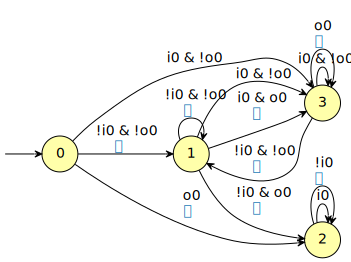

In [19]:
# lily09 -- without labels because formulas are too long
a8 = spot.ltlf_to_mtdfa("GFi0 -> (!o0 & G(!o0 -> ((!o0 U i0) & (i0 -> Fo0))) & GFo0)")
display(a8.show(labels=False), a8.as_twa(False))

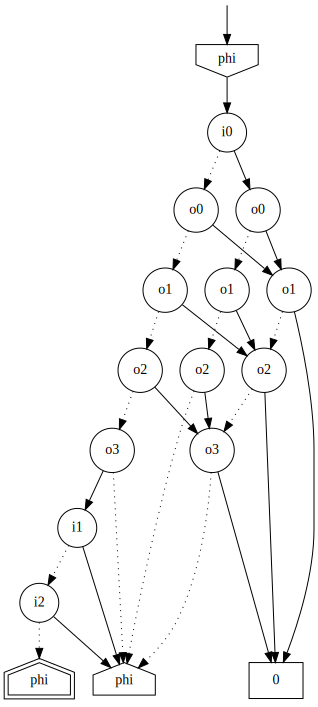

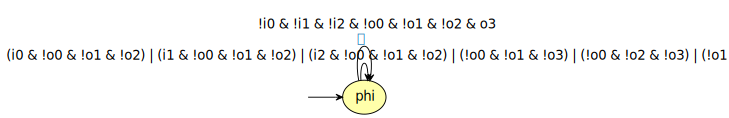

In [20]:
# lily18 -- without labels because formulas are too long
phi = "G(!(o0 & o1) & !(o0 & o2) & !(o0 & o3) & !(o1 & o2) & !(o1 & o3) & !(o2 & o3)) & (GFi0 -> GFo0) & (GFi1 -> GFo1) & (GFi2 -> GFo2) & GFo3"
a9 = spot.ltlf_to_mtdfa(phi)
a9.names[0] = spot.formula("phi") # Rename the formula for cosmetics
display(a9, a9.as_twa())

For comparison, here is the DFA we obtain via the historical LTLf->LTL->DBA->DFA construction.

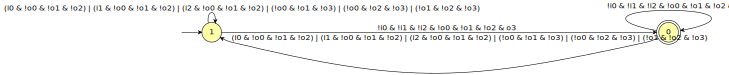

In [21]:
a10 = spot.translate(phi, "finite", "deterministic"); a10

In [22]:
spot.are_equivalent(a10, a9.as_twa()) # This is Büchi equivalence, but it doesn't matter in this case.

True

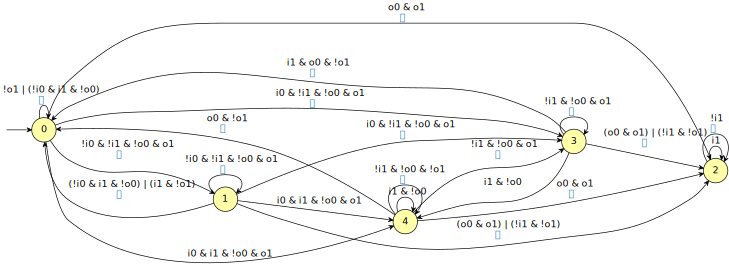

In [23]:
# lily19 -- without labels because formulas are too long
f = "GFi1 -> G(o1 -> (!(o0 & o1) & (o1 U i1) & (o0 -> (o0 U i1)) & (i0 -> Fo0) & Fo1))"
a11 = spot.ltlf_to_mtdfa(f)
display(a11.show(labels=False), a11.as_twa(False))

On the above example, we can see how transition-based acceptance can save three states (copies of 0, 2, and 4).  Here is the state-based version for comparison.

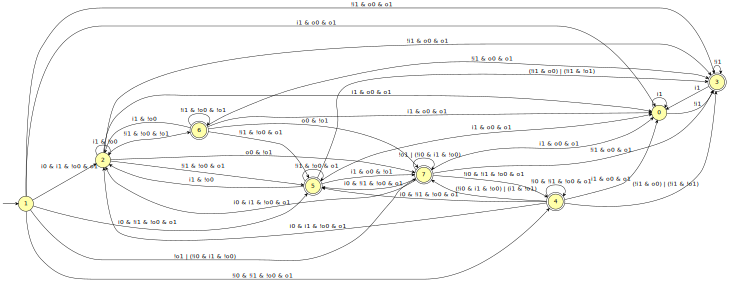

In [24]:
spot.translate(f, "finite", "deterministic")

# DFA Minimization

The MTBDD-based DFA allows a very simple implementation of minimization by partition refinement, similar to what is used in Mona.

  1. Assume all terminal belong to the same class, numbered 0.
  2. Rewrite all MTBDDs by relabeling each terminal by its class number (preserving the acceptance bit)
  3. Group all states in new classes according to their new BDD representation, giving each class a new number.
  4. Loop to 2 until the number of classes is stable.

For the purpose of the above algorithm, *false*, and *true* should treated as terminals (i.e., assigned a class and rewritten).  The the actual implementation then performs a final pass on the result to put *false* and *true* back.

Let's find some formulas on which this minimization is effective.

In [25]:
import spot.gen as sg
from timeit import default_timer as timer

In [26]:
print("           states                    time          ")
print("       -------------     --------------------------")
print("       DFA  min  ref        DFA  DFA+min        ref")
for i, f in enumerate(sg.ltl_patterns(sg.LTL_LILY_PATTERNS)):
    t1 = timer()
    dfa = spot.ltlf_to_mtdfa(f)
    t1b = timer()
    mindfa = spot.minimize_mtdfa(dfa)
    t2 = timer()
    
    n1, n2 = dfa.num_states(), mindfa.num_states()
    mark = ">" if n1 > n2 else " "
    
    t3 = timer()
    ref = spot.translate(f, "finite", "deterministic", xargs="tls-impl=0")
    t4 = timer()
    
    ref = ref.num_states()
    t1b -= t1
    t2 -= t1
    t4 -= t3
    
    tmark = '='
    if t4 > t2:
        tmark = "<"
    elif t4 < t2:
        tmark = ">"
    
    print(f"lily{i+1:<3} {n1:2} {mark} {n2:2}   {ref:2}   {t1b * 1000:6.2f}ms {t2 * 1000:6.2f}ms {tmark} {t4 * 1000:6.2f}ms")

           states                    time          
       -------------     --------------------------
       DFA  min  ref        DFA  DFA+min        ref
lily1    6    6    7     0.16ms   0.19ms <   0.57ms
lily2   11 >  9   12     0.07ms   0.11ms <   0.67ms
lily3   15 > 13   14     0.08ms   0.12ms <   1.27ms
lily4   23 > 21   23     0.11ms   0.37ms <   1.66ms
lily5   18 > 16   19     0.09ms   0.14ms <   1.39ms
lily6   30 > 25   30     0.12ms   0.19ms <   2.47ms
lily7    8    8    9     0.05ms   0.08ms <   0.68ms
lily8    1    1    2     0.02ms   0.04ms <   0.21ms
lily9    4    4    6     0.04ms   0.05ms <   0.28ms
lily10   4    4    7     0.03ms   0.05ms <   0.53ms
lily11   4    4    4     0.04ms   0.05ms <   0.36ms
lily12   8 >  6    7     0.04ms   0.06ms <   0.44ms
lily13   2    2    2     0.02ms   0.04ms <   0.21ms
lily14   1    1    2     0.05ms   0.07ms <   1.07ms
lily15   8    8    9     0.04ms   0.07ms <   0.96ms
lily16  22   22   23     0.12ms   0.16ms <   3.28ms
lily17   1  

The columns labeled DFA refer to the MTDFA construction, and show the number of states and time of the construction.

The columns labeled min refer to the minimized MTDFA; the time includes the time of the translation.

The "ref" column refers to the historical LTLf->LTL->DBA->DFA pipeline, that produces a state-based minimal DFA.  (Note that this pipeline performs some LTL simplification on the formula, that the LTLf->MTDBA construction does not do. The `tls-impl=0` option disables implication-based simplifications, to save some time.)

Let's look at a the two instances where the reduction is effective and output fewer than 10 states

In [27]:
def showlily(n, labels=False):
    f = sg.ltl_pattern(sg.LTL_LILY_PATTERNS, n) 
    print("-- before minimization --\n")
    aut = spot.ltlf_to_mtdfa(f)
    if not labels:
        for i in range(aut.num_roots()):
            print(f"state {i}: {aut.names[i]}")
    display(aut.show(labels=labels), aut.as_twa(labels))
    print("-- after minimization --\n")
    minaut = spot.minimize_mtdfa(aut)
    if not labels:
        for i in range(minaut.num_roots()):
            print(f"state {i}: {minaut.names[i]}")
    display(minaut.show(labels=labels), minaut.as_twa(labels))

-- before minimization --

state 0: G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 1: (o0 | X(o0 | Xo0)) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 2: !o0 & (o0 | X(o0 | Xo0)) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 3: (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 4: !o0 & (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 5: (o0 | Xo0) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 6: (o0 | Xo0) & (o0 | X(o0 | Xo0)) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 7: (o0 | Xo0) & (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 8: (o0 | Xo0) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 9: o0 & G(i2 -> (X(o0 | X(o0 | X

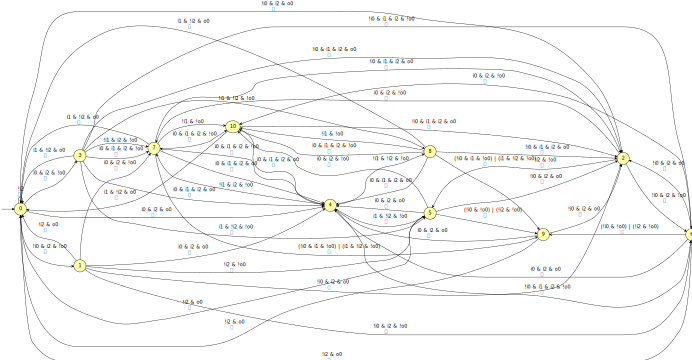

-- after minimization --

state 0: G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 1: (o0 | X(o0 | Xo0)) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 2: !o0 & (o0 | X(o0 | Xo0)) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 3: (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 4: !o0 & (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 5: (o0 | Xo0) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 6: (o0 | Xo0) & (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 7: o0 & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))
state 8: o0 & (o0 | X(o0 | Xo0)) & (!o0 U i1) & G(i2 -> (X(o0 | X(o0 | Xo0)) & (o0 -> X!o0) & (i0 -> X(!o0 U i1))))


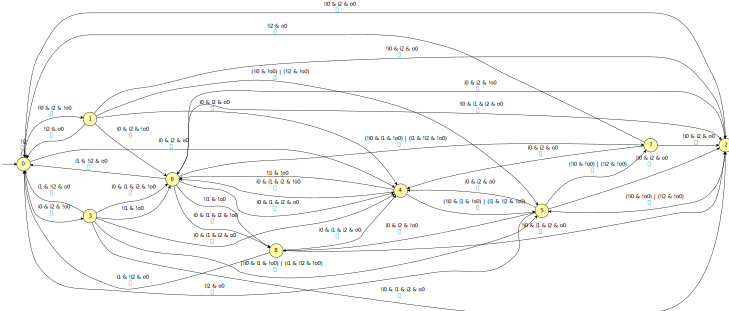

In [28]:
showlily(2)

-- before minimization --

state 0: G!o1 | G(i1 -> Fo0) | G(i0 -> Fo1)
state 1: G!o1 | G(i0 -> Fo1) | (Fo0 & G(i1 -> Fo0))
state 2: G(i1 -> Fo0) | G(i0 -> Fo1)
state 3: G(i0 -> Fo1) | (Fo0 & G(i1 -> Fo0))
state 4: G!o1 | G(i1 -> Fo0) | (Fo1 & G(i0 -> Fo1))
state 5: G!o1 | (Fo0 & G(i1 -> Fo0)) | (Fo1 & G(i0 -> Fo1))
state 6: G(i1 -> Fo0) | (Fo1 & G(i0 -> Fo1))
state 7: (Fo0 & G(i1 -> Fo0)) | (Fo1 & G(i0 -> Fo1))


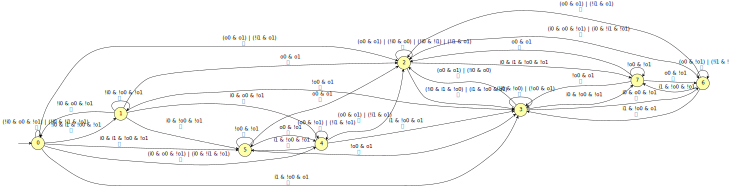

-- after minimization --

state 0: G!o1 | G(i1 -> Fo0) | G(i0 -> Fo1)
state 1: G!o1 | G(i0 -> Fo1) | (Fo0 & G(i1 -> Fo0))
state 2: G(i1 -> Fo0) | G(i0 -> Fo1)
state 3: G(i0 -> Fo1) | (Fo0 & G(i1 -> Fo0))
state 4: G(i1 -> Fo0) | (Fo1 & G(i0 -> Fo1))
state 5: (Fo0 & G(i1 -> Fo0)) | (Fo1 & G(i0 -> Fo1))


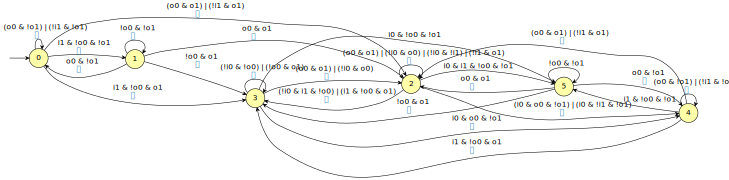

In [29]:
showlily(12)

# Examples that caused problems at some point

A large automaton that reduces to false.

In [30]:
f = "!i1 & F(o1 & X[!]!o1 & (!o2 | (!o0 & !o1) | Go1 | (o0 & !o2 & X[!]!o0) | (!o0 & (!i0 | !i1) & X[!]!o0) | (!o1 & (i0 | !i1) & X[!]!o1) | (i0 & Go0))) & G(i1 | o2 | X[!]!i1) & G(!i1 | F!i1) & G(!o2 | X[!]i1)"
dfa = spot.ltlf_to_mtdfa(f)
display(dfa.show(labels=False))
spot.minimize_mtdfa(dfa).show(labels=False)

Because the minimization has to turns constants false and true to terminals, it is a bit tricky to turn the terminal back into false/true especially in automata were "accepting false" or "rejecting true" are used as these two have to be kept as terms.  The following translations are already minimal, but they used to highlight issues with previous implementations of the minimization.

In [31]:
a = spot.ltlf_to_mtdfa("X[!](1) | Ga")
display_inline(a, spot.minimize_mtdfa(a))

In [32]:
a = spot.ltlf_to_mtdfa("X[!](b & X[!](1)) | Ga | X[!](c & X[!]X(0))")
display_inline(a.show(labels=True), spot.minimize_mtdfa(a))

In [33]:
a = spot.ltlf_to_mtdfa("X(0) | Ga")
display_inline(a.show(labels=True), spot.minimize_mtdfa(a))